In [1]:
import os
from os.path import dirname, abspath, join

import sys
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Load local libraries
# ROOT contais the project directory 
os.chdir(dirname(os.getcwd()))
os.getcwd()

'/home/ubuntu/master_thesis'

In [3]:
# Import local libraries
from src.logger import set_logger as sl

# Load transformations
from src.transformations.CC_RRC_RVF_RHF_RA import get_transform as gt_train
from src.transformations.CC_R import get_transform as gt_valid
from src.dataset import FundusDataset
from src.RAMdatset import FundusDatasetRAM
from src.plot_images import plot_images
from src.train_validation import train_validation_phase

In [4]:
# Set-up logger
try:
    if logger is None:
        logger = sl("info")
except:
    logger = sl("info")

# Parameters

In [10]:
# Put data
epochs        = 100
lr            = 0.001
batch_size    = 256

num_workers   = os.cpu_count()
num_workers   = 128

is_pretrained = False

im_size       = (300, 300)
is_grayscale  = False

data          = abspath('/mnt/data/ukbb_300x300/')
target_train  = abspath('./data/ukbb_metadata_qc_train.csv')
target_valid  = abspath('./data/ukbb_metadata_qc_validation.csv')

name = f"ukbb-sex-raw-{im_size[0]}x{im_size[1]}_iv3-bs{batch_size}-lr{str(lr)[2:]}"

model_pth     = abspath(f'./output/models/{name}.pth')

device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
######################################################################################
# Initial report
logger.info(f"System Python version  = {sys.version}")
logger.info(f"System Pytorch version = {torch.__version__}")
logger.info(f"System usable CPUs     = {os.cpu_count()}")

# Device setting and CUDA report 
logger.info(f"System training device = {device}")
if  torch.cuda.is_available():
    logger.info(f"System CUDA version    = {torch.version.cuda}")
    logger.info(f"System CUDA count      = {torch.cuda.device_count()}")
    logger.info(f"System CUDA name       = {torch.cuda.get_device_name()}")
    
# Load train and validation dataset
logger.info(f"Path working directory = {os.getcwd()}")
logger.info(f"Path input data        = {data}")
logger.info(f"Path to target train   = {target_train}")
logger.info(f"Path to target valid   = {target_valid}")
logger.info(f"Path model             = {model_pth}")

# Starting momentum and learning rate
logger.info(f"Model learning rate    = {lr}")
logger.info(f"Model batch_size       = {batch_size}")
logger.info(f"Model num_workers      = {num_workers}")
logger.info(f"Model pretrained       = {is_pretrained}")

2021-03-17 11:55:28,902 - INFO - System Python version  = 3.7.9 (default, Aug 31 2020, 12:42:55) 
[GCC 7.3.0]
2021-03-17 11:55:28,904 - INFO - System Pytorch version = 1.6.0
2021-03-17 11:55:28,904 - INFO - System usable CPUs     = 96
2021-03-17 11:55:28,906 - INFO - System training device = cuda:0
2021-03-17 11:55:28,907 - INFO - System CUDA version    = 10.2
2021-03-17 11:55:28,908 - INFO - System CUDA count      = 8
2021-03-17 11:55:28,909 - INFO - System CUDA name       = Tesla T4
2021-03-17 11:55:28,910 - INFO - Path working directory = /home/ubuntu/master_thesis
2021-03-17 11:55:28,911 - INFO - Path input data        = /mnt/data/ukbb_300x300
2021-03-17 11:55:28,912 - INFO - Path to target train   = /home/ubuntu/master_thesis/data/ukbb_metadata_qc_train.csv
2021-03-17 11:55:28,913 - INFO - Path to target valid   = /home/ubuntu/master_thesis/data/ukbb_metadata_qc_validation.csv
2021-03-17 11:55:28,914 - INFO - Path model             = /home/ubuntu/master_thesis/output/models/ukbb-s

# Dataset

In [7]:
#imgs_dir=None, target_file=None, scale=1, target_size=512, augment=True
logger.info(f"Loading datasets")
dataset = dict()
dataset["train"] = FundusDatasetRAM(imgs_dir=data, target_file=target_train, target="sex", augment=True)
dataset["valid"] = FundusDatasetRAM(imgs_dir=data, target_file=target_valid, target="sex", augment=False)

# Get the size of the datsets train and valid(ation)
size = dict()
size["train"] = len(dataset["train"])
size["valid"] = len(dataset["valid"])
logger.info(f"Dataset size training   = {size['train']}")
logger.info(f"Dataset size validation = {size['valid']}")
logger.info(f"Dataset labels/classes  = {dataset['train'].classes}")

2021-03-17 11:36:02,991 - INFO - Loading datasets
2021-03-17 11:40:13,556 - INFO - Dataset size training   = 120000
2021-03-17 11:40:13,558 - INFO - Dataset size validation = 10910
2021-03-17 11:40:13,559 - INFO - Dataset labels/classes  = ['female', 'male']


2021-03-17 11:55:38,034 - INFO - Loading dataloaders
2021-03-17 11:55:38,035 - INFO - Plot sample images
female  male  male  male  male  male  male  male


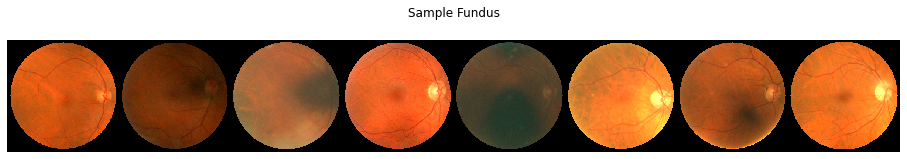

In [12]:
# Dataloader for train and valid(ation)
logger.info(f"Loading dataloaders")
dataloader = dict()
dataloader["train"] = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
dataloader["valid"] = DataLoader(dataset["valid"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

######################################################################################
# Get sample images
logger.info(f"Plot sample images")
plot_images(dataloader["valid"], dataset["valid"].classes, title="Sample Fundus", save=name)

In [13]:
# Load model
model = models.inception_v3(pretrained=is_pretrained,
                            aux_logits=False)

logger.info(f"Model loading            = {model.__class__.__name__}")

# Get number of features in the model
n_ftrs = model.fc.in_features
logger.info(f"Model number of features = {n_ftrs}")

# Add linear layer to the data
model.fc = nn.Linear(n_ftrs, len(dataset["train"].classes))

######################################################################################
# Send model to device, 
# if CUDA count is greater than 1 use multiple GPUs
model = model.to(device)
usable_devices =list(range(torch.cuda.device_count()))
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model, device_ids=usable_devices, output_device=device)
    logger.info(f"Let's use {torch.cuda.device_count()} GPUs!")

######################################################################################
# Get Optimization and crossentropy
criterion = nn.CrossEntropyLoss()

#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
optimizer = optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

######################################################################################
results = train_validation_phase(model=model,
                               dataset=dataset,
                               dataloader = dataloader,
                               device=device,
                               epochs=epochs,
                               criterion=criterion,
                               optimizer=optimizer,
                               save = model_pth,
                               logger=logger)

2021-03-17 11:56:28,170 - INFO - Model loading            = Inception3
2021-03-17 11:56:28,171 - INFO - Model number of features = 2048
2021-03-17 11:56:28,308 - INFO - Let's use 8 GPUs!
2021-03-17 11:57:36,433 - INFO - Epoch [  1/100] - Batch [     0/120000] ( 0%) - Loss 0.7063
2021-03-17 11:59:26,155 - INFO - Epoch [  1/100] - Batch [ 25600/120000] (21%) - Loss 0.6979
2021-03-17 12:00:48,719 - INFO - Epoch [  1/100] - Batch [ 51200/120000] (43%) - Loss 0.6773
2021-03-17 12:02:10,367 - INFO - Epoch [  1/100] - Batch [ 76800/120000] (64%) - Loss 0.6857
2021-03-17 12:03:32,290 - INFO - Epoch [  1/100] - Batch [102400/120000] (85%) - Loss 0.6982
2021-03-17 12:04:29,883 - INFO - Current lr: 0.001
2021-03-17 12:04:29,885 - INFO - train, Loss: 0.6907 Acc: 0.5530
2021-03-17 12:05:12,765 - INFO - Epoch [  1/100] - Batch [     0/ 10910] ( 0%) - Loss 0.6844
2021-03-17 12:05:33,339 - INFO - Current lr: 0.001
2021-03-17 12:05:33,340 - INFO - valid, Loss: 0.6743 Acc: 0.5813
2021-03-17 12:05:33,341

Exception ignored in: <function _releaseLock at 0x7f99a725d170>
Traceback (most recent call last):
  File "/home/ubuntu/.miniconda3/envs/mt/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


RuntimeError: DataLoader worker (pid(s) 404681, 404682, 404683, 404684, 404685, 404686, 404687, 404688, 404689, 404690, 404691, 404692, 404693, 404695, 404696, 404697, 404698, 404699, 404700, 404701, 404702, 404703, 404704, 404705, 404706, 404707, 404708, 404709, 404710, 404711, 404712, 404713, 404714, 404715, 404716, 404717, 404718, 404719, 404720, 404721, 404722, 404723, 404724, 404725, 404726, 404727, 404728, 404729, 404730, 404731, 404732, 404733, 404734, 404735, 404736, 404737, 404738, 404739, 404740, 404741, 404742, 404743, 404744, 404745, 404746, 404747, 404748, 404749, 404750, 404751, 404752, 404753, 404754, 404755, 404756, 404757, 404758, 404759, 404760, 404761, 404762, 404763, 404764, 404765, 404766, 404767, 404768, 404769, 404770, 404771, 404772) exited unexpectedly